# Main_Quest04
# 폐렴X-ray 판독기 모델링

**X-RAY 사진을보고 환자가 폐렴인지 아닌지 판별하는 모델을 만드는 퀘스트 입니다.**

**train 데이터와 검증데이터가 매우 적게 있어서 데이터 증강 + 오버 샘플링을 진행 하였고,
Resnet-18 모델 구조를 사용하였습니다.
결과는 70% 정확도와 71% 정밀도, 94%의 재현율 을 보여주는 모델을 만들긴 하였으나, 그 전에 수십번 에폭을 돌린 것들은
68% 미만의 매우 좋지 않은 결과가 나왔습니다.**

## 순서

- 텐서플로우 버전 확인
- GPU 가동
- 환경설정
- 데이터 불러오기
- 검증 데이터 분할
- 오버샘플링
- 모델 구성
- 모델 컴파일 및 옵티마이저 설정
- 모델 학습 및 콜백함수 추가
- 결과
- 회고

## 텐서플로우 버전 확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## GPU 가동

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


## 환경설정

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 데이터 불러오기

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 12
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 검증데이터 부족으로 인한 train_data 분할

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1156_bacteria_3101.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


### 분할 한 후의 train 와 val 데이터셋 갯수

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1065
Pneumonia images count in training set: 3120


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 각 정상과 폐렴 이미지의 라벨링

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

## 데이터 부족으로 인한 과적합일 것 같아 오버샘플링 시작

- 계속 데이터 증강 기법을 사용하면 변형이 이상하게 될 뿐더러, X-ray 특성상 좌우 반전이기에 의미가 없다고 생각
- 오버샘플링으로 데이터를 보충 하는 방법을 선택

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

def oversample(img, label):
    # Normal 이미지인 경우에만 적용
    if not label:  # 폐렴이 아닌 경우 (label이 False인 경우)
        img = tf.image.random_flip_left_right(img)
        # 다른 오버샘플링 기법도 추가 가능

    return img, label
def oversample2(img, label):
    # Normal 또는 Pneumonia 이미지인 경우에 적용
    if not label:  # 폐렴이 아닌 경우 (label이 False인 경우)
        img = tf.image.random_flip_left_right(img)
        # 다른 오버샘플링 기법도 추가 가능
    elif label:  # 폐렴인 경우 (label이 True인 경우)
        # 폐렴에 대한 오버샘플링 기법 추가
        # 예시로서, 수평으로 뒤집는 것과 수직으로 뒤집는 것을 랜덤하게 적용
        img = tf.image.random_flip_left_right(img)
    return img, label



In [30]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(train_ds)
oversampled_train_ds = train_ds.filter(lambda img, label: not label).repeat().map(oversample, num_parallel_calls=AUTOTUNE)
train_ds = tf.data.Dataset.concatenate(train_ds, oversampled_train_ds)
print(train_ds)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(oversample2, num_parallel_calls=AUTOTUNE)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ConcatenateDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>


In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def augment(image, label):
    # 좌우 반전
    image = tf.image.random_flip_left_right(image)

    return image, label

In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

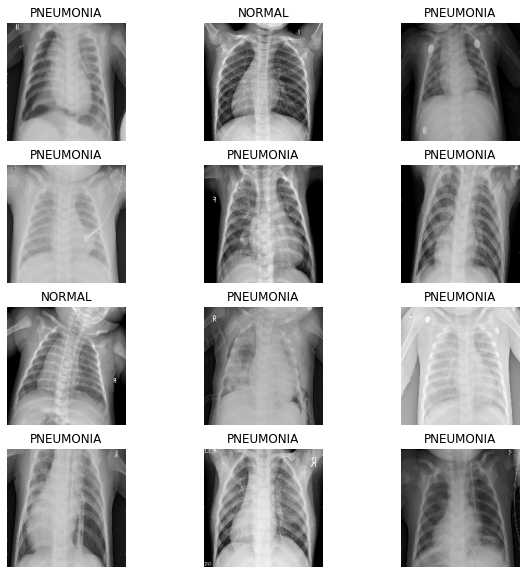

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 모델 구성

In [19]:
import tensorflow as tf

def residual_block(x, filters, kernel_size=3, strides=1):
    y = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)

    y = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    # Skip - connection 부분
    if strides > 1 or x.shape[-1] != filters:
        x = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    y = tf.keras.layers.Add()([x, y])
    y = tf.keras.layers.ReLU()(y)

    return y

def build_resnet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64, strides=1)
    x = residual_block(x, filters=64, strides=1)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128, strides=1)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256, strides=1)
    
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512, strides=1)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### 가중치를 변경해 보아도 지속적인 0.60대가 나와서 원상복구

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 옵티마이저 및 컴파일

In [21]:
from tensorflow.keras import optimizers
optimizer = tf.keras.optimizers.Adam(0.001)

with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

## 모델 학습 + 체크포인트 및 얼리스탑핑 추가

In [22]:
from tensorflow.keras import callbacks
with tf.device('/GPU:0'):
    check_point_cb = callbacks.ModelCheckpoint('resnet18_model.h5', save_best_only=True)
    early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                  restore_best_weights=True)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[check_point_cb, early_stopping_cb]
    )

Epoch 1/20
348/348 [==============================] - 132s 220ms/step - loss: 8.4529 - accuracy: 0.8357 - precision: 0.9390 - recall: 0.8129 - val_loss: 6.8170 - val_accuracy: 0.7289 - val_precision: 0.7289 - val_recall: 1.0000
Epoch 2/20
348/348 [==============================] - 145s 416ms/step - loss: 0.5857 - accuracy: 0.9624 - precision: 0.8571 - recall: 0.4524 - val_loss: 1.0462 - val_accuracy: 0.2711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
348/348 [==============================] - 145s 419ms/step - loss: 0.8896 - accuracy: 0.9974 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0044 - val_accuracy: 0.2720 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
348/348 [==============================] - 147s 425ms/step - loss: 0.0257 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.7576 - val_accuracy: 0.2711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
348/348 [============================

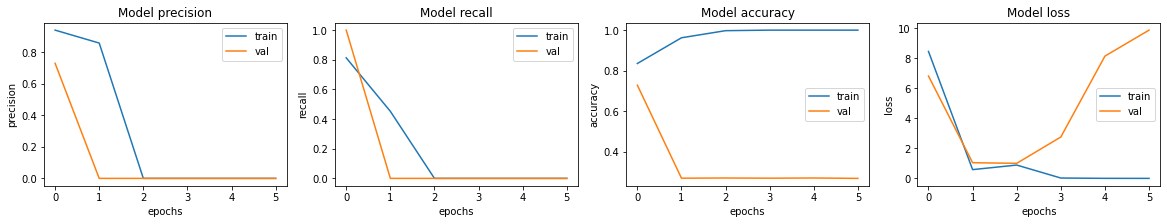

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

52/52 [==============================] - 5s 90ms/step - loss: 0.9278 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.9277614951133728,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


### 지속된 시도후 첫번째로 70퍼센트 이상의 정확도를 보였을 때

- 모든 레이어에 L2 규제 적용
- 배치사이즈 12
- 훈련데이터의 정상폐 갯수가 부족하여 오버샘플링 적용 및 검증데이터는 정상, 폐렴 둘다 오버샘플링
- 전체 데이터 증강 으로 좌우반전을 주었음 다른 것들을 줘도 되지만, x-ray 사진 자체가 흑백개념이라 색조 변화를 주거나 노이즈를 주면 폐렴으로 인식되거나 할수 있기 때문에 제외하였고, 상,하 반전도 항상 같은자세에서 찍기 때문에 배제 하였음

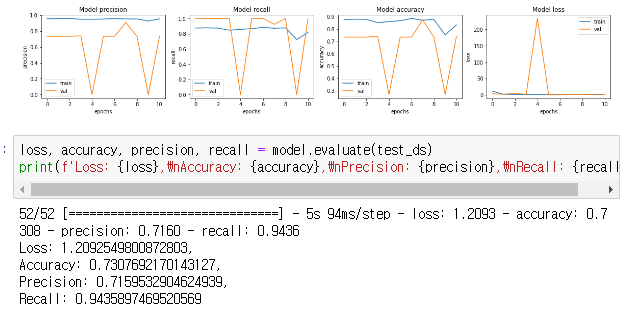

### 과적합이 일어나는 것 같아서 드롭아웃 0.2를 각 레이어의 블록이 끝날 때 마다 추가 해보았음

- 모든 레이어에 L2 규제 적용
- 배치사이즈 12
- 훈련데이터의 정상폐 갯수가 부족하여 오버샘플링 적용 및 검증데이터는 정상, 폐렴 둘다 오버샘플링
- 전체 데이터 증강 으로 좌우반전을 주었음 다른 것들을 줘도 되지만, x-ray 사진 자체가 흑백개념이라 색조 변화를 주거나 노이즈를 주면 폐렴으로 인식되거나 할수 있기 때문에 제외하였고, 상,하 반전도 항상 같은자세에서 찍기 때문에 배제 하였음
- ( + ) 각 블록별 dropout 0.2 씩 추가

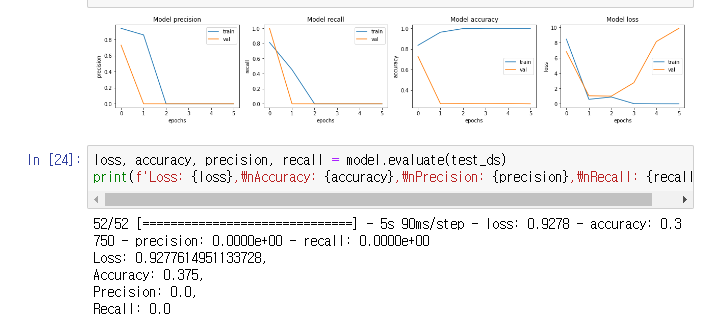

## 회고

정말 많은 시도를 했습니다... 드라큘라 모양이 나와서 또 과적합인가? 하고 드롭아웃을 써봤는데 결과는 처참하게 나왔네요
과거 과정에서도 resnet-50 모델만 유독 오래걸리고 정확도가 떨어졌었는데 그때는 데이터가 1만개정도였습니다.

근데 이번에도 resnet-18 모델에서 정확도가 더 낮게 나오네요.. 제가 잘 처리를 못한 탓이겠죠
주말에 가상환경도 고치고해서 다시 해봐야 할 것 같습니다.

시각화와 결과보고는 또 마지막에 생각나서 결과보고 제일 잘나온것과 드롭아웃을 하면 펑 터져버릴 수 있구나 만 남겨버렸네요 하하..

- K
    - 다양한 방법으로 시도를 해보았다.
- P
    - 지속적으로 70%대를 도달하지 못했던 점
    - 또.. 시각화를 안했고, 또한 결과들을 나열하지 않고 마지막에 생각해버린 점
- T
    - 데이터증강, 오버 샘플링, 드롭아웃, L2규제화 추가, 가중치 변경, 기본 파라미터(배치사이즈, 에폭) 변경, 옵티마이저 학습률 변경 등 다양한 시도를 해보았음